<a href="https://colab.research.google.com/github/Dakshina09/Matrix-Calculator/blob/main/Design_Credit_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DILI


In [ ]:
pip install pandas scikit-learn tensorflow rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 48.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, mean_squared_error, r2_score, mean_absolute_error, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
data = pd.read_csv('DILI_data1.csv')

In [ ]:
data.isnull().sum()
data = data.dropna()

In [ ]:
data.head()

,Chemical name,SMILE,class.
0,Aurothioglucose,[H][C@]1([S-])O[C@]([H])(CO)[C@@]([H])(O)[C@](...,1
1,DemecariumBromide,CN(CCCCCCCCCCN(C)C(=O)Oc1cccc(c1)[N+](C)(C)C)C...,1
2,Dextromethorphan,[H][C@]12Cc3ccc(OC)cc3[C@@]3(CCCC[C@]13[H])CCN2C,0
3,Ergotamine,[H][C@@]12CCCN1C(=O)[C@]([H])(Cc1ccccc1)N1C(=O...,0
4,Beclomethasone,[H][C@]1(C)C[C@@]2([H])[C@]3([H])CCC4=CC(=O)C=...,0


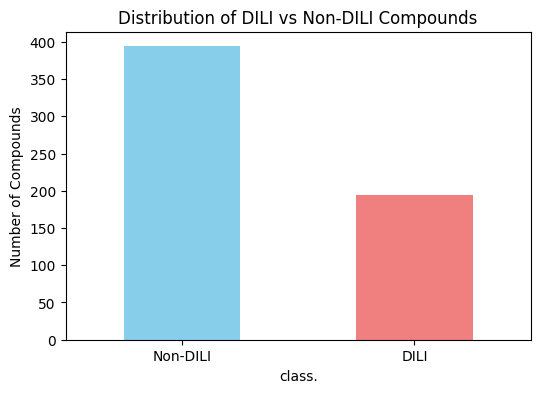

In [ ]:
plt.figure(figsize=(6, 4))
data['class.'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Distribution of DILI vs Non-DILI Compounds')
plt.ylabel('Number of Compounds')
plt.xticks([0, 1], ['Non-DILI', 'DILI'], rotation=0)
plt.show()

In [ ]:
def calculate_descriptors(smile):
    mol = Chem.MolFromSmiles(smile)
    if mol:
        descriptors = {
            'MolWt': Descriptors.MolWt(mol),
            'LogP': Descriptors.MolLogP(mol),
            'NumHDonors': Descriptors.NumHDonors(mol),
            'NumHAcceptors': Descriptors.NumHAcceptors(mol),
        }
        return descriptors
    else:
        return {}


In [ ]:
data['Descriptors'] = data['SMILE'].apply(calculate_descriptors)

In [ ]:
descriptor_df = pd.DataFrame(data['Descriptors'].tolist())

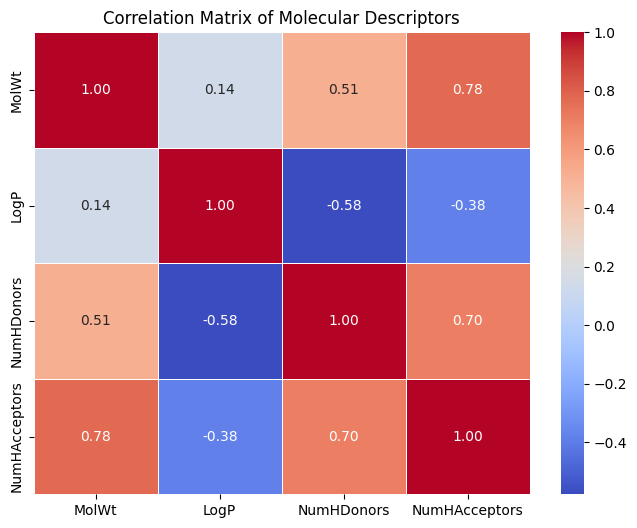

In [ ]:
corr_matrix = descriptor_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Molecular Descriptors')
plt.show()

In [ ]:
categorical_column_name = 'Chemical name'
if categorical_column_name in data.columns:
    label_encoder = LabelEncoder()
    data[categorical_column_name + '_encoded'] = label_encoder.fit_transform(data[categorical_column_name])
else:
    print(f"Error: Column '{categorical_column_name}' not found in the DataFrame.")

In [ ]:
X = pd.concat([descriptor_df, data[categorical_column_name + '_encoded']], axis=1)
y = data['class.']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train_scaled, y_train)

y_pred_logreg = logreg_model.predict(X_test_scaled)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Classification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_logreg))

Logistic Regression Accuracy: 0.6101694915254238
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.55      0.13      0.21        47
           1       0.62      0.93      0.74        71

    accuracy                           0.61       118
   macro avg       0.58      0.53      0.47       118
weighted avg       0.59      0.61      0.53       118



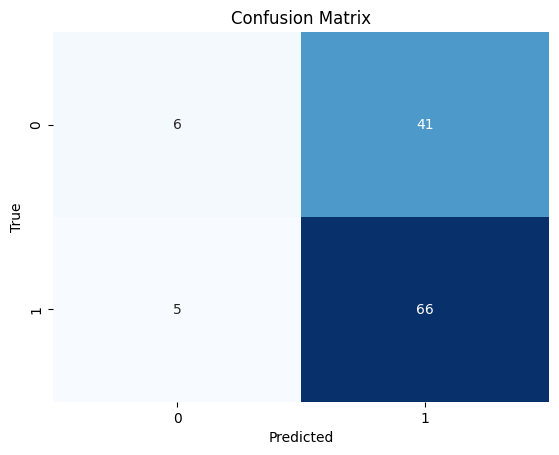

In [ ]:

cm = confusion_matrix(y_test, y_pred_logreg)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
svc_model = SVC(kernel='linear')
svc_model.fit(X_train_scaled, y_train)

# Predict and evaluate the SVM model
y_pred_svc = svc_model.predict(X_test_scaled)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svc))
print("Classification Report (SVM):")

SVM Accuracy: 0.6016949152542372
Classification Report (SVM):


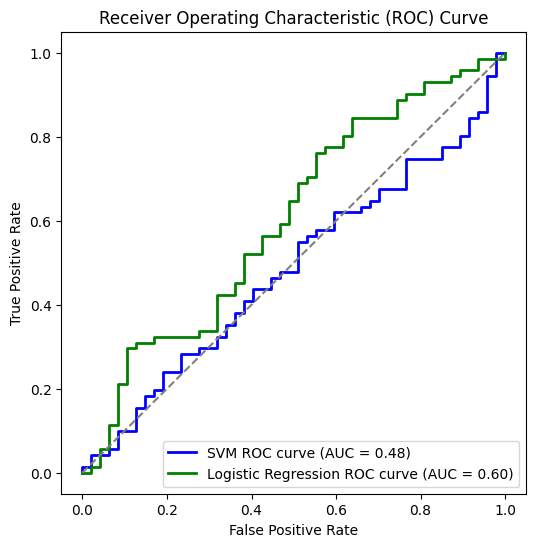

In [ ]:
fpr_svc, tpr_svc, _ = roc_curve(y_test, svc_model.decision_function(X_test_scaled))
roc_auc_svc = auc(fpr_svc, tpr_svc)

fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg_model.predict_proba(X_test_scaled)[:, 1])
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

plt.figure(figsize=(6, 6))
plt.plot(fpr_svc, tpr_svc, color='blue', lw=2, label=f'SVM ROC curve (AUC = {roc_auc_svc:.2f})')
plt.plot(fpr_logreg, tpr_logreg, color='green', lw=2, label=f'Logistic Regression ROC curve (AUC = {roc_auc_logreg:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

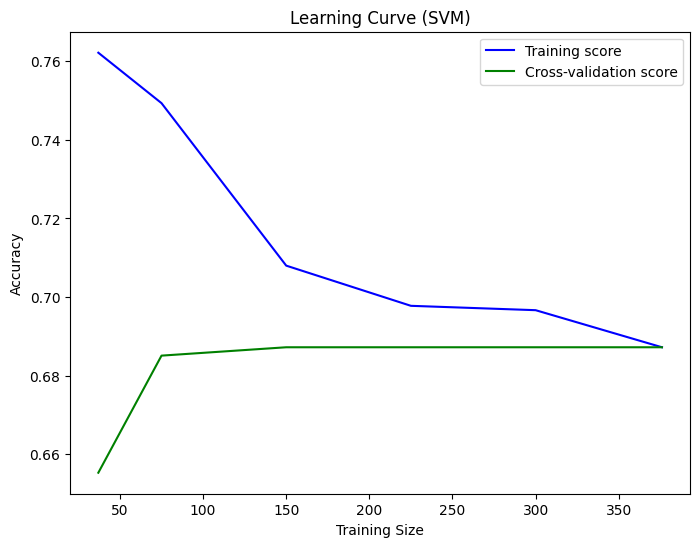

In [ ]:
#Step 9: Learning Curve for SVM

train_sizes, train_scores, test_scores = learning_curve(svc_model, X_train_scaled, y_train, cv=5, n_jobs=-1,train_sizes=[0.1, 0.2, 0.4, 0.6, 0.8, 1.0])

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score', color='blue')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Cross-validation score', color='green')
plt.title('Learning Curve (SVM)')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

In [ ]:
linear_model = LogisticRegression(max_iter=1000)  # Linear model for regression task
linear_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
y_pred_linear = linear_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred_linear)
print(f"Mean Squared Error (Logistic Regression): {mse}")

Mean Squared Error (Logistic Regression): 0.3898305084745763


#Dataset 2
without SMILE

In [ ]:
data = pd.read_csv("DILI_data2.csv")

In [ ]:
mapping_dict = {
    'Ambiguous DILI-concern': 3,
    'vMost-DILI-Concern': 2,
    'vLess-DILI-Concern': 1,
    'vNo-DILI-Concern': 0
}

mapping_dict1 = {
    'Box warning': 3,
    'Warnings and precautions': 2,
    'Adverse reactions': 1,
    'No match': 0
}


data['label No'] = data['Label Section'].map(mapping_dict1).astype(float)


data['DILIScore'] = data['vDILIConcern'].map(mapping_dict).astype(float)
data.head()

,LTKBID,Compound Name,Severity Class,Label Section,vDILIConcern,Version,label No,DILIScore
0,LT00003,mercaptopurine,8,Warnings and precautions,vMost-DILI-Concern,1,2.0,2.0
1,LT00004,acetaminophen,5,Warnings and precautions,vMost-DILI-Concern,2,2.0,2.0
2,LT00006,azathioprine,5,Warnings and precautions,vMost-DILI-Concern,1,2.0,2.0
3,LT00009,chlorpheniramine,0,No match,vNo-DILI-Concern,2,0.0,0.0
4,LT00011,clofibrate,3,Warnings and precautions,vLess-DILI-Concern,1,2.0,1.0


In [ ]:
mapping_dict = {
    'Ambiguous DILI-concern': 3,
    'vMost-DILI-Concern': 2,
    'vLess-DILI-Concern': 1,
    'vNo-DILI-Concern': 0
}

mapping_dict1 = {
    'Warnings and precautions': 2,
    'Adverse reactions': 1,
    'No match': 0
}


data['label No'] = data['Label Section'].map(mapping_dict1).astype(float)
data['DILIScore'] = data['vDILIConcern'].map(mapping_dict).astype(float)
data.head()

,LTKBID,Compound Name,Severity Class,Label Section,vDILIConcern,Version,label No,DILIScore
0,LT00003,mercaptopurine,8,Warnings and precautions,vMost-DILI-Concern,1,2.0,2.0
1,LT00004,acetaminophen,5,Warnings and precautions,vMost-DILI-Concern,2,2.0,2.0
2,LT00006,azathioprine,5,Warnings and precautions,vMost-DILI-Concern,1,2.0,2.0
3,LT00009,chlorpheniramine,0,No match,vNo-DILI-Concern,2,0.0,0.0
4,LT00011,clofibrate,3,Warnings and precautions,vLess-DILI-Concern,1,2.0,1.0


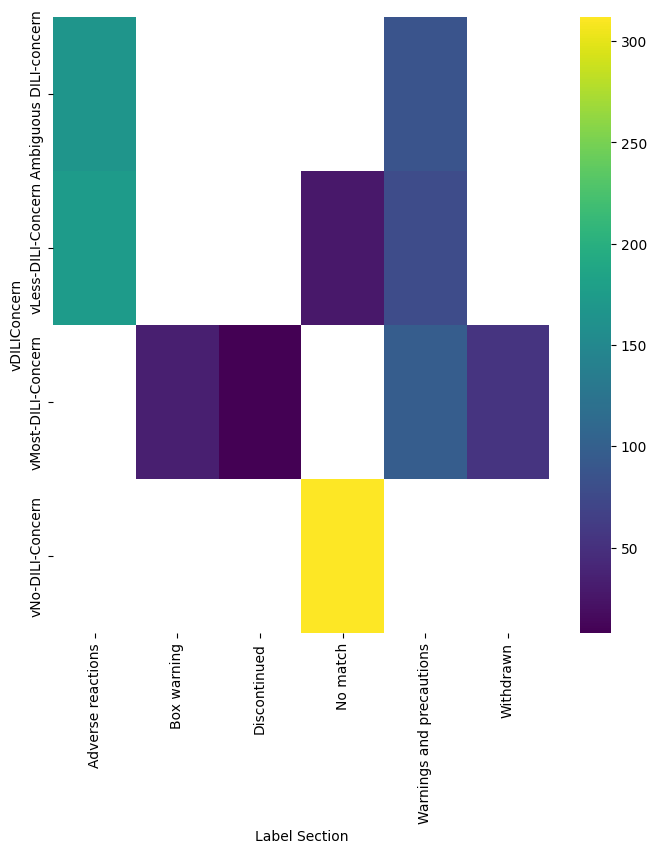

In [ ]:
# @title Label Section vs vDILIConcern

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['vDILIConcern'].value_counts()
    for x_label, grp in data.groupby('Label Section')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Label Section')
_ = plt.ylabel('vDILIConcern')

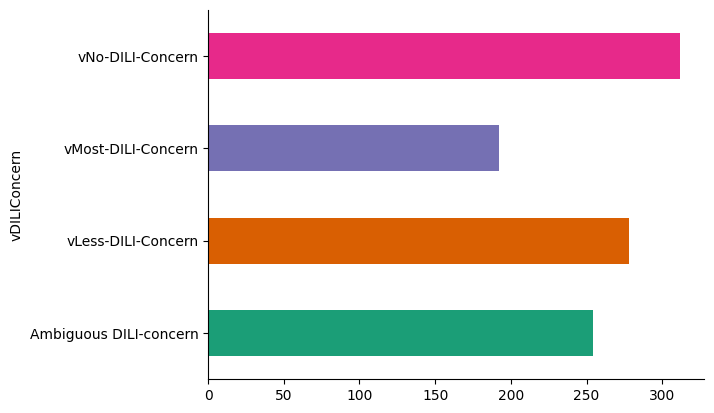

In [ ]:
# @title vDILIConcern

from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('vDILIConcern').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

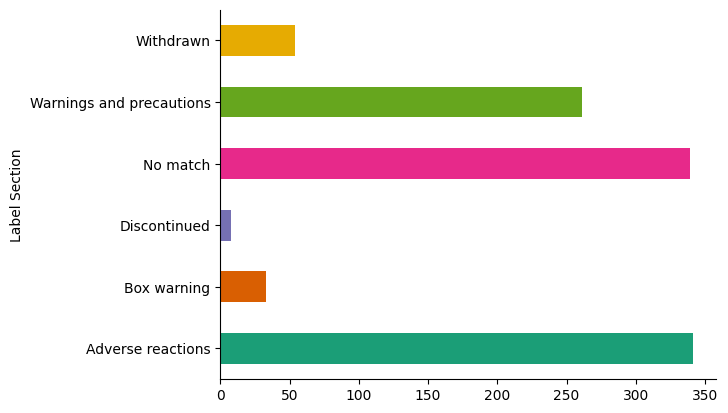

In [ ]:
# @title Label Section

from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('Label Section').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

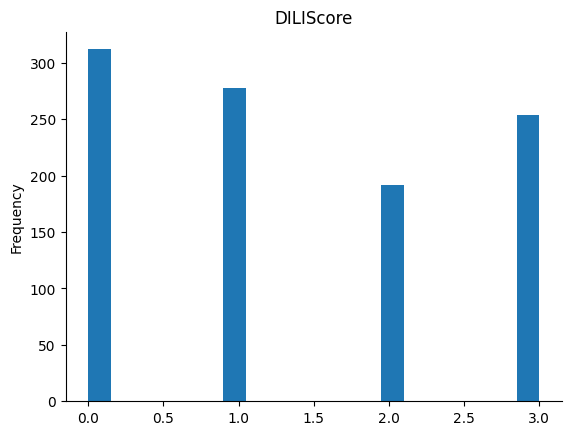

In [ ]:
# @title DILIScore

from matplotlib import pyplot as plt
data['DILIScore'].plot(kind='hist', bins=20, title='DILIScore')
plt.gca().spines[['top', 'right',]].set_visible(False)

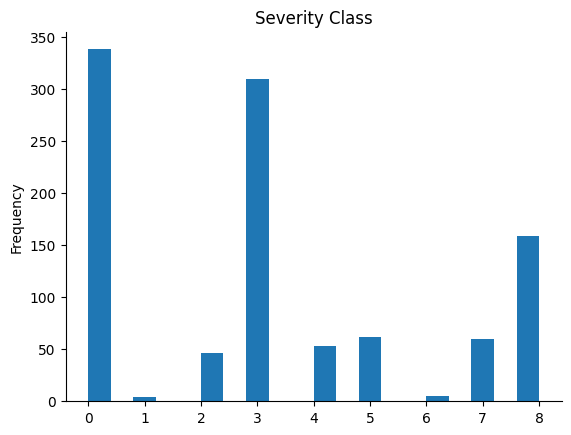

In [ ]:
# @title Severity Class

from matplotlib import pyplot as plt
data['Severity Class'].plot(kind='hist', bins=20, title='Severity Class')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
X = data.drop(columns=['LTKBID', 'Compound Name', 'vDILIConcern', 'DILIScore'])
y = data['DILIScore']

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Label Section']),
    ],
    remainder='passthrough'
)

Random forest regressor

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [ ]:
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"RANDON FOREST REGRESSOR- Mean Squared Error: {mse_rf}")
print(f"RANDON FOREST REGRESSOR-R² Score: {r2_rf}")
print("-" * 50)

RANDON FOREST REGRESSOR- Mean Squared Error: 0.49419275119311273
RANDON FOREST REGRESSOR-R² Score: 0.6128638518936258
--------------------------------------------------


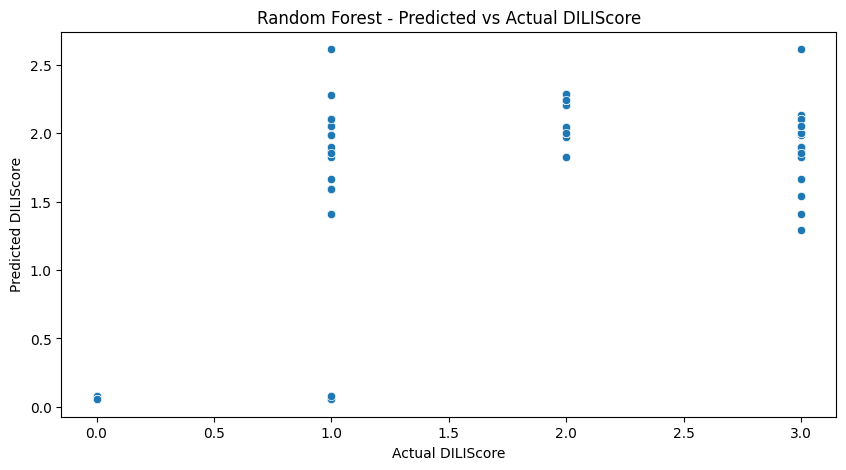

In [ ]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test, y=y_pred_rf)
plt.xlabel("Actual DILIScore")
plt.ylabel("Predicted DILIScore")
plt.title("Random Forest - Predicted vs Actual DILIScore")
plt.show()


Linear regression

In [ ]:
linear_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

In [ ]:
linear_pipeline.fit(X_train, y_train)
y_pred_linear = linear_pipeline.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
print(f"LINEAR REGRESSION - Mean Squared Error: {mse_linear}")
print(f"LINEAR REGRESSION - R² Score: {r2_linear}")
print(f"LINEAR REGRESSION - Mean Absolute Erro Score: {mae_linear}")
print(f"LINEAR REGRESSION - Root Mean Squared Error Score: {rmse_linear}")
print("-" * 50)

LINEAR REGRESSION - Mean Squared Error: 0.48094930726768814
LINEAR REGRESSION - R² Score: 0.6232383785465839
LINEAR REGRESSION - Mean Absolute Erro Score: 0.5209913783973508
LINEAR REGRESSION - Root Mean Squared Error Score: 0.6935050881339575
--------------------------------------------------


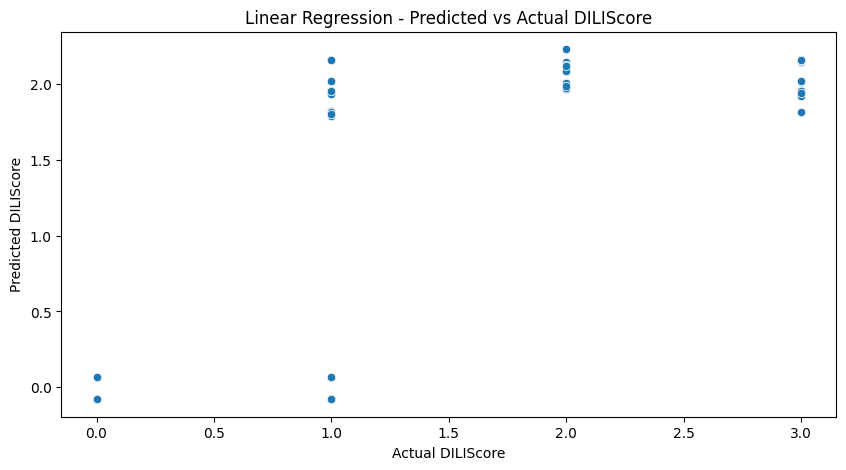

In [ ]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test, y=y_pred_linear)
plt.xlabel("Actual DILIScore")
plt.ylabel("Predicted DILIScore")
plt.title("Linear Regression - Predicted vs Actual DILIScore")
plt.show()

Logistic regression

In [ ]:
y_train_class = y_train.astype(int)
y_test_class = y_test.astype(int)

logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('classifier', LogisticRegression(max_iter=200))
])

In [ ]:
logistic_pipeline.fit(X_train, y_train_class)
y_pred_logistic = logistic_pipeline.predict(X_test)
accuracy_logistic = accuracy_score(y_test_class, y_pred_logistic)
print(f"Accuracy: {accuracy_logistic}")
print("Confusion Matrix:\n", confusion_matrix(y_test_class, y_pred_logistic))
print("Classification Report:\n", classification_report(y_test_class, y_pred_logistic, zero_division=1))
print("-" * 50)

Accuracy: 0.7788461538461539
Confusion Matrix:
 [[56  0  0  0]
 [10 19  0 24]
 [ 0  0 47  1]
 [ 0 11  0 40]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92        56
           1       0.63      0.36      0.46        53
           2       1.00      0.98      0.99        48
           3       0.62      0.78      0.69        51

    accuracy                           0.78       208
   macro avg       0.77      0.78      0.76       208
weighted avg       0.77      0.78      0.76       208

--------------------------------------------------


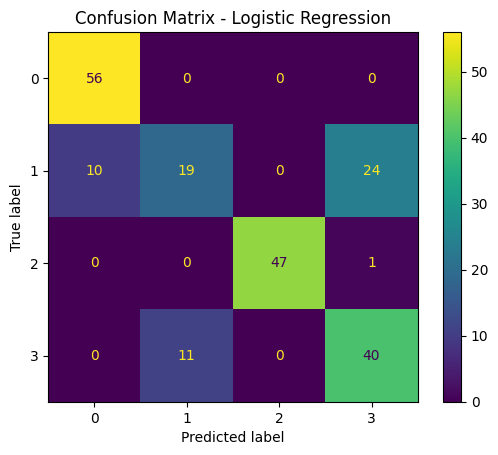

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test_class, y_pred_logistic)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


SVM

In [ ]:
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('classifier', SVC(kernel='linear'))
])

In [ ]:
svm_pipeline.fit(X_train, y_train_class)
y_pred_svm = svm_pipeline.predict(X_test)
accuracy_svm = accuracy_score(y_test_class, y_pred_svm)
print(f"Accuracy: {accuracy_svm}")
print("Confusion Matrix:\n", confusion_matrix(y_test_class, y_pred_svm))
print("Classification Report:\n", classification_report(y_test_class, y_pred_svm, zero_division=1))
print("-" * 50)

Accuracy: 0.7932692307692307
Confusion Matrix:
 [[56  0  0  0]
 [10 16  0 27]
 [ 0  2 45  1]
 [ 0  3  0 48]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92        56
           1       0.76      0.30      0.43        53
           2       1.00      0.94      0.97        48
           3       0.63      0.94      0.76        51

    accuracy                           0.79       208
   macro avg       0.81      0.80      0.77       208
weighted avg       0.81      0.79      0.77       208

--------------------------------------------------


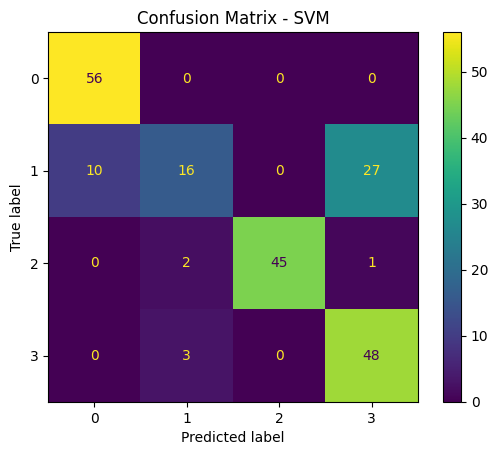

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test_class, y_pred_svm)
plt.title("Confusion Matrix - SVM")
plt.show()

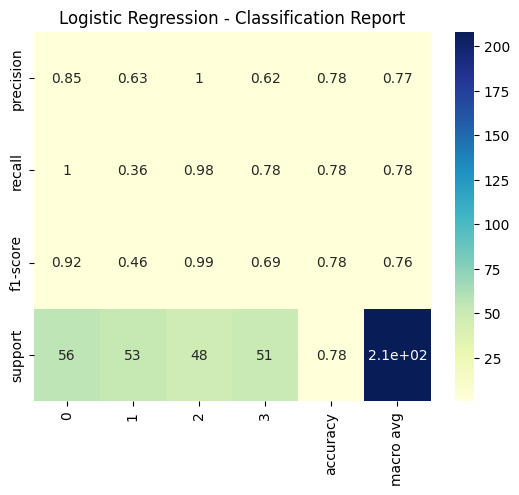

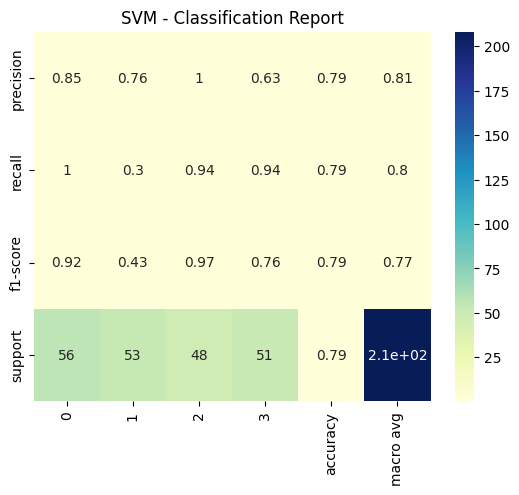

In [ ]:
def plot_classification_report(y_true, y_pred, title):
    report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).T
    sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap="YlGnBu")
    plt.title(title)
    plt.show()

# Logistic Regression Classification Report Heatmap
plot_classification_report(y_test_class, y_pred_logistic, "Logistic Regression - Classification Report")

# SVM Classification Report Heatmap
plot_classification_report(y_test_class, y_pred_svm, "SVM - Classification Report")

NEURAL NETWORK

In [ ]:
nn_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('scaler', StandardScaler()),('imputer', SimpleImputer(strategy='mean'))])
X_train_processed = nn_pipeline.fit_transform(X_train)

In [ ]:
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_train_processed, y_train_class, test_size=0.2, random_state=42)

In [ ]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_nn.shape[1],)),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')  # Output layer for 4 classes
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train_nn, y_train_nn, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_nn, y_test_nn)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5176 - loss: 1.2478 - val_accuracy: 0.5789 - val_loss: 0.9819
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6103 - loss: 0.9836 - val_accuracy: 0.7293 - val_loss: 0.8012
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6892 - loss: 0.8646 - val_accuracy: 0.7368 - val_loss: 0.6742
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7012 - loss: 0.7394 - val_accuracy: 0.7368 - val_loss: 0.5816
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7319 - loss: 0.6420 - val_accuracy: 0.7594 - val_loss: 0.5163
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7135 - loss: 0.5915 - val_accuracy: 0.7444 - val_loss: 0.4828
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7205 - loss: 0.5477 - val_accuracy: 0.7669 - val_loss: 0.4568
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7413 - loss: 0.5403 - val_accuracy: 0.7820 - val_loss

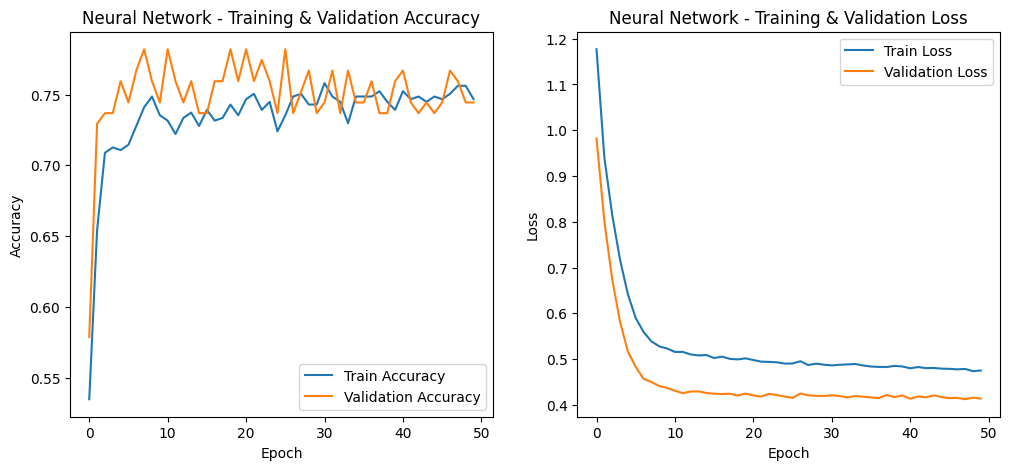

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Neural Network - Training & Validation Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Neural Network - Training & Validation Loss')
plt.legend()

plt.show()